# ✅ Импорты

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os

import pickle

from time import time

import numpy as np
import pandas as pd

from sklearn.linear_model import HuberRegressor

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

from sklift.models import (
    SoloModel,
    TwoModels,
    ClassTransformation
)
from sklift.metrics import (
    uplift_at_k,
    qini_auc_score,
    weighted_average_uplift,
    uplift_by_percentile
)

from catboost import (
    CatBoostClassifier,
    Pool
)

from upninja.utils.Viz import (
    plot_qini_curve,
    plot_uplift_by_percentile
)
from upninja.utils.Score import uplift_score
from upninja.models import (
    Spaces,
    Selection
)

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

# ✅ Загрузим X5 Retail Hero dataset

In [3]:
DATA_PATH = 'data/retailhero-uplift/data'
SEED = 8

In [4]:
%%time

clients = pd.read_csv(os.path.join(DATA_PATH, 'clients.csv'))
products = pd.read_csv(os.path.join(DATA_PATH, 'products.csv'))
purchases = pd.read_csv(os.path.join(DATA_PATH, 'purchases.csv'))
train = pd.read_csv(os.path.join(DATA_PATH, 'uplift_train.csv'))
test = pd.read_csv(os.path.join(DATA_PATH, 'uplift_test.csv'))

CPU times: user 18.6 s, sys: 5.65 s, total: 24.3 s
Wall time: 26.6 s


## ⚒️ Препроцессинг X5 Retail Hero dataset

In [5]:
%%time

product_cols = ['product_id', 'is_alcohol', 'is_own_trademark']

purchases = purchases.merge(products[product_cols], 
                            on='product_id',
                            how='left'
                           )

purchases['transaction_datetime'] = pd.to_datetime(purchases['transaction_datetime'])

# агрегаты по клиенту:
client_features = purchases.groupby('client_id').agg(
    n_transactions=('transaction_id', 'nunique'),
    sum_trn_sum=('trn_sum_from_iss', 'sum'),
    mean_trn_sum=('trn_sum_from_iss', 'mean'),
    sum_quantity=('product_quantity', 'sum'),
    alcohol_bought=('is_alcohol', 'sum'),
    own_trademark_bought=('is_own_trademark', 'sum'),
    n_unique_products=('product_id', 'nunique'),
    n_days_active=('transaction_datetime', lambda x: x.nunique()),
    last_transaction_days_ago=('transaction_datetime', lambda x: (pd.Timestamp('2019-03-18') - x).max().days)
)

CPU times: user 35.1 s, sys: 2.37 s, total: 37.5 s
Wall time: 38 s


In [6]:
%%time

clients['first_issue_date'] = pd.to_datetime(clients['first_issue_date'])
clients['first_redeem_date'] = pd.to_datetime(clients['first_redeem_date'])

clients['issue_ts'] = clients['first_issue_date'].map(pd.Timestamp.timestamp)
clients['redeem_ts'] = clients['first_redeem_date'].apply(
    lambda x: x.timestamp() if pd.notna(x) else np.nan
)

CPU times: user 492 ms, sys: 22.3 ms, total: 514 ms
Wall time: 515 ms


In [7]:
# объединяем с агрегатами:
train_full = train.merge(clients, on='client_id', how='left')
train_full = train_full.merge(client_features, on='client_id', how='left')

test_full = test.merge(clients, on='client_id', how='left')
test_full = test_full.merge(client_features, on='client_id', how='left')

In [8]:
train_full.to_csv(os.path.join(DATA_PATH, 'uplift_train_preproc.csv'))
test_full.to_csv(os.path.join(DATA_PATH, 'uplift_test_preproc.csv'))

## ⚙️ Baseline

In [9]:
%%time

train_full = pd.read_csv(os.path.join(DATA_PATH, 'uplift_train_preproc.csv'))
test_full = pd.read_csv(os.path.join(DATA_PATH, 'uplift_test_preproc.csv'))

CPU times: user 301 ms, sys: 37.3 ms, total: 338 ms
Wall time: 338 ms


In [10]:
train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200039 entries, 0 to 200038
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Unnamed: 0                 200039 non-null  int64  
 1   client_id                  200039 non-null  object 
 2   treatment_flg              200039 non-null  int64  
 3   target                     200039 non-null  int64  
 4   first_issue_date           200039 non-null  object 
 5   first_redeem_date          182493 non-null  object 
 6   age                        200039 non-null  int64  
 7   gender                     200039 non-null  object 
 8   issue_ts                   200039 non-null  float64
 9   redeem_ts                  182493 non-null  float64
 10  n_transactions             200039 non-null  int64  
 11  sum_trn_sum                200039 non-null  float64
 12  mean_trn_sum               200039 non-null  float64
 13  sum_quantity               20

In [11]:
target_name = 'target'
treatment_name = 'treatment_flg'

baseline_selector = [
    feat for feat in train_full.select_dtypes(exclude='object').columns
         if feat not in ('id', 'Unnamed: 0', target_name, treatment_name)
         and not train_full[feat].isna().any().any()
]

baseline_selector

['age',
 'issue_ts',
 'n_transactions',
 'sum_trn_sum',
 'mean_trn_sum',
 'sum_quantity',
 'alcohol_bought',
 'own_trademark_bought',
 'n_unique_products',
 'n_days_active',
 'last_transaction_days_ago']

In [12]:
train_full[baseline_selector].describe()

,age,issue_ts,n_transactions,sum_trn_sum,mean_trn_sum,sum_quantity,alcohol_bought,own_trademark_bought,n_unique_products,n_days_active,last_transaction_days_ago
count,200039.000000,2.000390e+05,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000
mean,46.417329,1.515492e+09,20.120821,8398.786037,75.437531,142.527997,1.916926,17.433061,75.287259,20.120781,96.268868
std,49.532475,1.759508e+07,17.732130,8627.434880,34.422622,140.550727,5.126671,19.139443,56.378792,17.732053,26.991088
min,-7491.000000,1.491330e+09,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000
25%,34.000000,1.500656e+09,8.000000,3096.000000,58.449771,53.000000,0.000000,5.000000,35.000000,8.000000,92.000000
50%,45.000000,1.510779e+09,15.000000,5996.000000,70.309524,104.000000,0.000000,12.000000,62.000000,15.000000,109.000000
75%,59.000000,1.529517e+09,27.000000,10863.000000,85.626551,188.000000,2.000000,23.000000,101.000000,27.000000,113.000000
max,1852.000000,1.552686e+09,320.000000,498973.000000,4427.000000,10614.000000,183.000000,489.000000,1364.000000,320.000000,116.000000


In [13]:
X_train_full = train_full[baseline_selector]
y_full = train_full[target_name]
treat_full = train_full[treatment_name]

X_test = test_full[[
    feat for feat in baseline_selector
         if feat not in ('target', 'treatment_flg', target_name, treatment_name)
]]

X_train, X_val, y_train, y_val, treat_train, treat_val = train_test_split(
    X_train_full, y_full, treat_full,
    test_size=0.2,
    random_state=SEED,
    stratify=treat_full.astype(str) + y_full.astype(str)
)

# Two-Model подход: обучаем отдельные модели для treatment и control
tm = TwoModels(
    estimator_trmnt=RandomForestClassifier(n_estimators=100, random_state=SEED),
    estimator_ctrl=RandomForestClassifier(n_estimators=100, random_state=SEED),
    method='vanilla'  # разность предсказаний: P(Y=1|X,T=1) - P(Y=1|X,T=0)
)

In [14]:
%%time

tm = TwoModels(
    estimator_trmnt=RandomForestClassifier(n_estimators=200, max_depth=8, random_state=SEED, n_jobs=-1),
    estimator_ctrl=RandomForestClassifier(n_estimators=200, max_depth=8, random_state=SEED, n_jobs=-1),
    method='vanilla'
)

tm.fit(X_train, y_train, treat_train)

uplift_val = tm.predict(X_val)

CPU times: user 25.6 s, sys: 378 ms, total: 26 s
Wall time: 3.04 s


## 🔮 Baseline Аналитика

### ⭐ Uplift at 30%

In [15]:
# ранжируем treatment и control отдельно:
#    -отбираем топ-30% клиентов по uplift’у, и среди них есть и treatment, и control

uplift_30 = uplift_at_k(
    y_true=y_val,
    uplift=uplift_val,
    treatment=treat_val,
    strategy='by_group',
    k=0.3
)
print(f'Uplift@30%: {uplift_30:.4f}')

Uplift@30%: 0.0524


### ⭐ Quini AUC

In [16]:
auqc = qini_auc_score(y_val, uplift_val, treat_val)
print(f"Qini AUC (AUQC): {auqc:.4f}")

Qini AUC (AUQC): 0.0081


### ⭐ Weighted average uplift

In [17]:
wau = weighted_average_uplift(y_val, uplift_val, treat_val, bins=10)
print(f"Weighted Average Uplift: {wau:.4f}")

Weighted Average Uplift: 0.0340


### ⭐ Uplift by percentiles

In [18]:
uplift_bins = uplift_by_percentile(
    y_true=y_val,
    uplift=uplift_val,
    treatment=treat_val,
    strategy='overall',
    bins=10,
    std=True,
    total=False
)

pd.DataFrame(uplift_bins)

,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,1963,2038,0.528782,0.460255,0.068527,0.011267,0.011041,0.015774
10-20,2053,1948,0.560643,0.517454,0.043189,0.010954,0.011322,0.015753
20-30,2031,1970,0.574101,0.526904,0.047198,0.010972,0.011249,0.015714
30-40,1993,2008,0.574511,0.558765,0.015746,0.011075,0.011081,0.015666
40-50,2039,1962,0.615007,0.573394,0.041613,0.010776,0.011166,0.015518
50-60,1984,2017,0.619960,0.607338,0.012622,0.010897,0.010874,0.015394
60-70,1974,2027,0.658561,0.620622,0.037940,0.010673,0.010778,0.015168
70-80,1992,2009,0.734438,0.712295,0.022143,0.009895,0.010100,0.014139
80-90,1970,2030,0.757360,0.718227,0.039134,0.009658,0.009985,0.013892


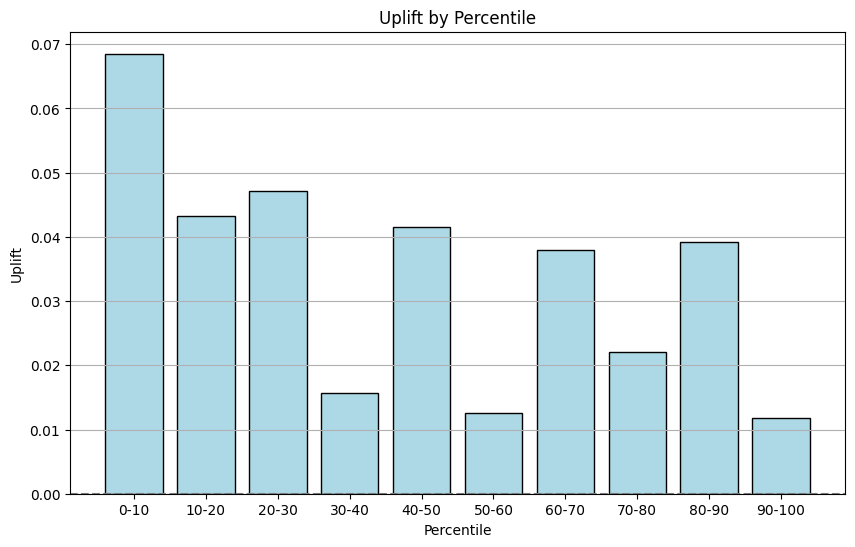

In [19]:
plot_uplift_by_percentile(
    y_val,
    uplift_val,
    treat_val
)
plt.show()

### ⭐ Qini curve

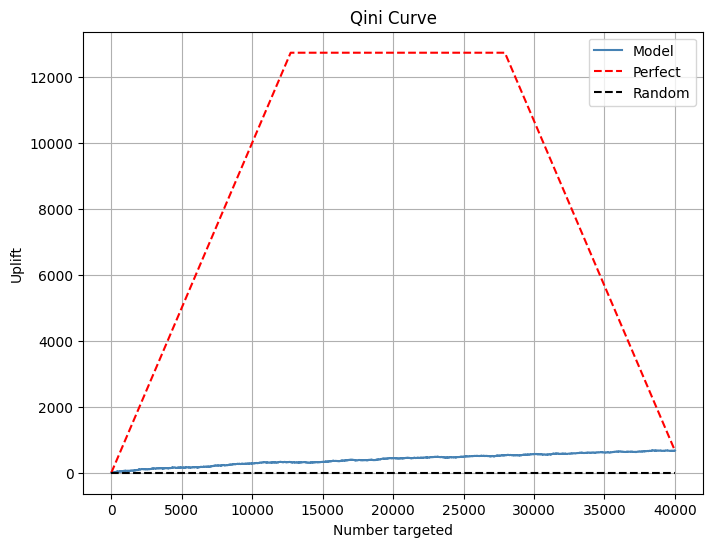

In [20]:
plot_qini_curve(y_val, uplift_val, treat_val, perfect=True)
plt.show()

# ✅ Добавим функцию для оценки Uplift-а

In [21]:
print('🚩Baseline uplift-score: ', uplift_score(uplift_val, treat_val, y_val))

🚩Baseline uplift-score:  0.052435880537001656


# ✅ Подберем лучший классический подход

In [4]:
train_full = pd.read_csv(os.path.join(DATA_PATH, 'uplift_train_preproc.csv'))
test_full = pd.read_csv(os.path.join(DATA_PATH, 'uplift_test_preproc.csv'))

In [5]:
target_name = 'target'
treatment_name = 'treatment_flg'
drop_feat = ['client_id', 'Unnamed: 0']

X_train_full = train_full.drop(drop_feat + [target_name, treatment_name], axis=1).copy()
X_test_full = test_full.drop(drop_feat, axis=1).copy()

y_full = train_full[target_name].copy()
treat_full = train_full[treatment_name].copy()

In [6]:
X_train_full.isna().any().any()

np.True_

In [7]:
X_test_full.isna().any().any()

np.True_

In [8]:
def missing_stats(dataset):
    res = []
    for col in dataset.columns:
        res.append([
            col,
            1.0 - np.mean(dataset[col].isnull()),
            dataset[col].dtype
        ])
    res = pd.DataFrame(res, columns=['feature', 'hitrate', 'dtype'])
    res = res.sort_values(by=['hitrate'], ascending=True)
    res.reset_index(drop=True, inplace=True)
    return res

res_missing = missing_stats(X_train_full)
res_missing

,feature,hitrate,dtype
0,first_redeem_date,0.912287,object
1,redeem_ts,0.912287,float64
2,first_issue_date,1.000000,object
3,age,1.000000,int64
4,gender,1.000000,object
5,issue_ts,1.000000,float64
6,n_transactions,1.000000,int64
7,sum_trn_sum,1.000000,float64
8,mean_trn_sum,1.000000,float64
9,sum_quantity,1.000000,float64


In [9]:
samples = [X_train_full, X_test_full]

fill_mice = res_missing[
                (res_missing['hitrate'] < 1) &
                ~(res_missing['dtype'] == 'object')
            ]['feature']
fill_mode = res_missing[
                (res_missing['hitrate'] < 1) &
                (res_missing['dtype'] == 'object')
            ]['feature']

for sample in samples:
    imputed = IterativeImputer(
        estimator=HuberRegressor(),
        max_iter=10,
        random_state=SEED
    ).fit_transform(sample[fill_mice])
    sample[fill_mice] = imputed
    sample[fill_mode] = sample[fill_mode].fillna(sample[fill_mode].mode())

In [10]:
to_dt = ['first_issue_date', 'first_redeem_date']

for sample in samples:
    for feat in to_dt:
        sample[feat] = pd.to_datetime(sample[feat], errors='coerce')
        sample[feat] = sample[feat].astype('int64') // 10**9
        sample[to_dt] = sample[to_dt].replace(-9223372036854775808, np.nan).fillna(-1)

In [11]:
X_train_full.isna().any().any()

np.False_

In [12]:
X_test_full.isna().any().any()

np.False_

In [13]:
X_train_full['gender'] = X_train_full['gender'].map({'M': 1, 'F': 0, 'U': -1})
X_test_full['gender'] = X_test_full['gender'].map({'M': 1, 'F': 0, 'U': -1})

In [14]:
X_train, X_val, y_train, y_val, treat_train, treat_val = train_test_split(
    X_train_full, y_full, treat_full,
    test_size=0.2,
    random_state=SEED,
    stratify=treat_full.astype(str) + y_full.astype(str)
)

In [33]:
cat_features = ['gender']

bm_cb = CatBoostClassifier(
    verbose=100, 
    cat_features=cat_features,
    random_state=SEED,
    thread_count=-1,
    iterations=1000
)

bm_rf = {
    'verbose': 100,
    'n_estimators': 100,
    'n_jobs': -1,
    'criterion': 'gini',
    'random_state': SEED
}

uplift_models = {
    'solo-model-cb': SoloModel(bm_cb.copy()),
    'class-transformation-cb': ClassTransformation(bm_cb.copy()),
    'two-models-undepended-cb': TwoModels(
                                    estimator_trmnt=bm_cb.copy(),
                                    estimator_ctrl=bm_cb.copy(),
                                    method='vanilla'
                             ),
    'two-models-depended-control-first-cb': TwoModels(
                                    estimator_trmnt=bm_cb.copy(),
                                    estimator_ctrl=bm_cb.copy(),
                                    method='ddr_control'
                             ),
    'two-models-depended-treatment-first-cb': TwoModels(
                                    estimator_trmnt=bm_cb.copy(),
                                    estimator_ctrl=bm_cb.copy(),
                                    method='ddr_treatment'
                             ),
    'solo-model-rf': SoloModel(RandomForestClassifier(**bm_rf)),
    'class-transformation-rf': ClassTransformation(RandomForestClassifier(**bm_rf)),
    'two-models-undepended-rf': TwoModels(
                                    estimator_trmnt=RandomForestClassifier(**bm_rf),
                                    estimator_ctrl=RandomForestClassifier(**bm_rf),
                                    method='vanilla'
                             ),
    'two-models-depended-control-first-rf': TwoModels(
                                    estimator_trmnt=RandomForestClassifier(**bm_rf),
                                    estimator_ctrl=RandomForestClassifier(**bm_rf),
                                    method='ddr_control'
                             ),
    'two-models-depended-treatment-first-rf': TwoModels(
                                    estimator_trmnt=RandomForestClassifier(**bm_rf),
                                    estimator_ctrl=RandomForestClassifier(**bm_rf),
                                    method='ddr_treatment'
                             )
}

res = []

for model_name, model in tqdm(uplift_models.items()):
    t_start = time()
    print(f'✅ start fitting: {model_name}')
    model.fit(X_train, y_train, treat_train)
    t_fit = time() - t_start
    uplift_val = model.predict(X_val)
    uplift_30 = uplift_at_k(
                    y_true=y_val,
                    uplift=uplift_val,
                    treatment=treat_val,
                    strategy='by_group',
                    k=0.3
                )
    auqc = qini_auc_score(
                y_val,
                uplift_val,
                treat_val
            )
    wau = weighted_average_uplift(
            y_val,
            uplift_val,
            treat_val, 
            bins=10
        )
    res.append([model_name, t_fit, uplift_30, wau, auqc])

res = pd.DataFrame(res, columns=['Approach', 'Fitting time', 'Uplift at 30%', 'WAU', 'AUQC'])

  0%|          | 0/10 [00:00<?, ?it/s]

✅ start fitting: solo-model-cb
Learning rate set to 0.089977
0:	learn: 0.6697650	total: 79.7ms	remaining: 1m 19s
100:	learn: 0.5464407	total: 1.93s	remaining: 17.2s
200:	learn: 0.5423457	total: 4.04s	remaining: 16.1s
300:	learn: 0.5388160	total: 6.13s	remaining: 14.2s
400:	learn: 0.5357533	total: 8.32s	remaining: 12.4s
500:	learn: 0.5325290	total: 10.3s	remaining: 10.3s
600:	learn: 0.5297384	total: 12.2s	remaining: 8.11s
700:	learn: 0.5269743	total: 14.2s	remaining: 6.04s
800:	learn: 0.5242708	total: 16.1s	remaining: 3.99s
900:	learn: 0.5214651	total: 18s	remaining: 1.97s


 10%|█         | 1/10 [00:20<03:00, 20.06s/it]

999:	learn: 0.5189700	total: 19.9s	remaining: 0us
✅ start fitting: class-transformation-cb
Learning rate set to 0.089977
0:	learn: 0.6922375	total: 20.6ms	remaining: 20.6s
100:	learn: 0.6858782	total: 1.86s	remaining: 16.5s
200:	learn: 0.6829835	total: 3.7s	remaining: 14.7s
300:	learn: 0.6795650	total: 5.61s	remaining: 13s
400:	learn: 0.6764241	total: 7.51s	remaining: 11.2s
500:	learn: 0.6735827	total: 9.54s	remaining: 9.51s
600:	learn: 0.6706306	total: 11.6s	remaining: 7.69s
700:	learn: 0.6678701	total: 13.7s	remaining: 5.82s
800:	learn: 0.6653441	total: 15.8s	remaining: 3.93s
900:	learn: 0.6628359	total: 17.8s	remaining: 1.96s


 20%|██        | 2/10 [00:40<02:40, 20.05s/it]

999:	learn: 0.6603972	total: 19.9s	remaining: 0us
✅ start fitting: two-models-undepended-cb
Learning rate set to 0.066936
0:	learn: 0.6763669	total: 10.9ms	remaining: 10.8s
100:	learn: 0.5555946	total: 1.14s	remaining: 10.1s
200:	learn: 0.5508824	total: 2.28s	remaining: 9.06s
300:	learn: 0.5457172	total: 3.46s	remaining: 8.03s
400:	learn: 0.5408680	total: 4.7s	remaining: 7.02s
500:	learn: 0.5369164	total: 5.83s	remaining: 5.81s
600:	learn: 0.5325074	total: 7s	remaining: 4.65s
700:	learn: 0.5288706	total: 8.16s	remaining: 3.48s
800:	learn: 0.5250093	total: 9.27s	remaining: 2.3s
900:	learn: 0.5214128	total: 10.5s	remaining: 1.16s
999:	learn: 0.5178955	total: 11.8s	remaining: 0us
Learning rate set to 0.066914
0:	learn: 0.6746781	total: 13.6ms	remaining: 13.5s
100:	learn: 0.5368217	total: 1.09s	remaining: 9.69s
200:	learn: 0.5314800	total: 2.23s	remaining: 8.88s
300:	learn: 0.5263553	total: 3.44s	remaining: 7.99s
400:	learn: 0.5218697	total: 4.57s	remaining: 6.83s
500:	learn: 0.5177119	tot

 30%|███       | 3/10 [01:03<02:32, 21.74s/it]

999:	learn: 0.4992177	total: 11.7s	remaining: 0us
✅ start fitting: two-models-depended-control-first-cb
Learning rate set to 0.066936
0:	learn: 0.6763669	total: 11.4ms	remaining: 11.4s
100:	learn: 0.5555946	total: 1.11s	remaining: 9.87s
200:	learn: 0.5508824	total: 2.19s	remaining: 8.71s
300:	learn: 0.5457172	total: 3.29s	remaining: 7.63s
400:	learn: 0.5408680	total: 4.39s	remaining: 6.56s
500:	learn: 0.5369164	total: 5.51s	remaining: 5.48s
600:	learn: 0.5325074	total: 6.61s	remaining: 4.39s
700:	learn: 0.5288706	total: 7.7s	remaining: 3.29s
800:	learn: 0.5250093	total: 8.8s	remaining: 2.19s
900:	learn: 0.5214128	total: 9.91s	remaining: 1.09s
999:	learn: 0.5178955	total: 11s	remaining: 0us
Learning rate set to 0.066914
0:	learn: 0.6727895	total: 10.8ms	remaining: 10.8s
100:	learn: 0.5352555	total: 1.08s	remaining: 9.66s
200:	learn: 0.5313254	total: 2.22s	remaining: 8.82s
300:	learn: 0.5265420	total: 3.45s	remaining: 8.02s
400:	learn: 0.5218804	total: 4.62s	remaining: 6.9s
500:	learn: 0

 40%|████      | 4/10 [01:26<02:13, 22.22s/it]

999:	learn: 0.4975460	total: 11.7s	remaining: 0us
✅ start fitting: two-models-depended-treatment-first-cb
Learning rate set to 0.066914
0:	learn: 0.6746781	total: 11.5ms	remaining: 11.5s
100:	learn: 0.5368217	total: 1.15s	remaining: 10.2s
200:	learn: 0.5314800	total: 2.3s	remaining: 9.13s
300:	learn: 0.5263553	total: 3.48s	remaining: 8.09s
400:	learn: 0.5218697	total: 4.66s	remaining: 6.96s
500:	learn: 0.5177119	total: 5.83s	remaining: 5.81s
600:	learn: 0.5136621	total: 7.01s	remaining: 4.65s
700:	learn: 0.5100111	total: 8.14s	remaining: 3.47s
800:	learn: 0.5065301	total: 9.37s	remaining: 2.33s
900:	learn: 0.5029463	total: 10.5s	remaining: 1.15s
999:	learn: 0.4992177	total: 11.6s	remaining: 0us
Learning rate set to 0.066936
0:	learn: 0.6749406	total: 17.3ms	remaining: 17.3s
100:	learn: 0.5548876	total: 1.08s	remaining: 9.65s
200:	learn: 0.5501897	total: 2.17s	remaining: 8.63s
300:	learn: 0.5452869	total: 3.27s	remaining: 7.6s
400:	learn: 0.5407129	total: 4.36s	remaining: 6.52s
500:	lea

 50%|█████     | 5/10 [01:50<01:53, 22.65s/it]

999:	learn: 0.5173694	total: 11.5s	remaining: 0us
✅ start fitting: solo-model-rf
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
building tree 8 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 9 of 100
building tree 10 of 100
building tree 7 of 100
building tree 1 of 100
building tree 6 of 100
building tree 11 of 100
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
building tree 12 of 100
building tree 13 of 100
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.5s
building tree 14 of 100
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.5s
building tree 15 of 100
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.5s
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   7 tasks     

 60%|██████    | 6/10 [01:55<01:06, 16.71s/it]

[Parallel(n_jobs=10)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  57 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  58 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  59 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  60 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  61 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  62 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  63 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  66 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  67 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  68 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  69 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  70 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  71 tasks      | elapsed:    0.1s
[Paralle

 70%|███████   | 7/10 [02:01<00:40, 13.39s/it]

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.4s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  14 tasks    

 80%|████████  | 8/10 [02:05<00:20, 10.36s/it]

[Parallel(n_jobs=10)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  89 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  91 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  93 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  95 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  97 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished
✅ start fitting: two-models-depended-control-first-rf
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
building tree 4 of 100
building tree 2 of 100
building tree 3 of 100
building tree 6 of 100
building tree 1 of 100
building tree 10 of 100
building tree 7 of 100
building tree 9 of 100
building tree 5 of 100
building tree 8 of 100
building tree 11 of 100
building tree 12 of 100
[Parallel(n_jobs=-1)]: Done 

 90%|█████████ | 9/10 [02:09<00:08,  8.40s/it]

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  15 tasks      | elaps

100%|██████████| 10/10 [02:14<00:00, 13.42s/it]

[Parallel(n_jobs=10)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  35 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  39 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  43 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  45 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  47 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  48 tasks      | elapsed:    0.1s
[Paralle

In [34]:
res

,Approach,Fitting time,Uplift at 30%,WAU,AUQC
0,solo-model-cb,20.024434,0.048928,0.030748,0.012106
1,class-transformation-cb,20.021005,0.065012,0.034198,0.018385
2,two-models-undepended-cb,23.710582,0.052461,0.032630,0.008699
3,two-models-depended-control-first-cb,22.907935,0.043792,0.033496,0.008077
4,two-models-depended-treatment-first-cb,23.382143,0.047955,0.031824,0.006552
5,solo-model-rf,4.926733,0.048129,0.033111,0.005358
6,class-transformation-rf,6.382054,0.050006,0.034225,0.005535
7,two-models-undepended-rf,3.676198,0.044483,0.033721,0.005597
8,two-models-depended-control-first-rf,3.849046,0.044657,0.034403,0.006491
9,two-models-depended-treatment-first-rf,4.121610,0.024143,0.032793,-0.000788


In [15]:
cb_params = Spaces.cb_hp_space
cb_params['random_state'] = SEED

rf_params = Spaces.rf_hp_space
rf_params['random_state'] = SEED

cb_tune = Selection.UpliftTune(
    base_model_class=CatBoostClassifier,
    uplift_model_class=ClassTransformation,
    data=X_train,
    target=y_train,
    treatment=treat_train,
    space=cb_params,
    scoring_metric='uplift',
    verbose=True
)

rf_tune = Selection.UpliftTune(
    base_model_class=RandomForestClassifier,
    uplift_model_class=ClassTransformation,
    data=X_train,
    target=y_train,
    treatment=treat_train,
    space=rf_params,
    scoring_metric='uplift',
    verbose=True
)

In [18]:
cb_tuned = cb_tune.tune()

with open('data/models/cb_best_params.pkl', 'wb') as f:
    pickle.dump(cb_tuned['best_params'], f)

best_cb = ClassTransformation(CatBoostClassifier(**cb_tuned['best_params']))
best_cb.fit(X_train, y_train, treat_train)

uplift_val_cb = best_cb.predict(X_val)
uplift_30_cb = uplift_at_k(
                y_true=y_val,
                uplift=uplift_val_cb,
                treatment=treat_val,
                strategy='by_group',
                k=0.3
            )

100%|██████████| 50/50 [00:00<?, ?trial/s, best loss=?]
Optimization completed. Best score: 0.0860
Best parameters: {'depth': 2, 'iterations': 146, 'l2_leaf_reg': 4.516883173245864, 'learning_rate': 0.11819868910962697, 'random_state': 8, 'thread_count': -1, 'verbose': False}


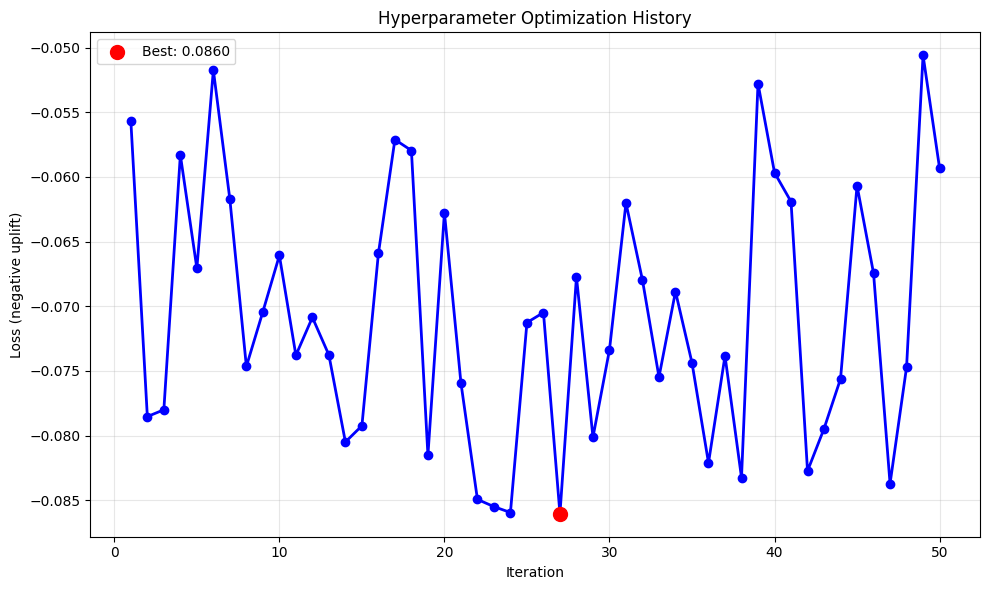

In [19]:
cb_tune.plot_optimization_history()

In [20]:
uplift_30_cb

np.float64(0.07529404687452879)

In [25]:
rf_tuned = rf_tune.tune()

with open('data/models/rf_best_params.pkl', 'wb') as f:
    pickle.dump(rf_tuned['best_params'], f)

best_rf = ClassTransformation(RandomForestClassifier(**rf_tuned['best_params']))
best_rf.fit(X_train, y_train, treat_train)

uplift_val_rf = best_rf.predict(X_val)
uplift_30_rf = uplift_at_k(
                y_true=y_val,
                uplift=uplift_val_rf,
                treatment=treat_val,
                strategy='by_group',
                k=0.3
            )

100%|██████████| 50/50 [00:00<?, ?trial/s, best loss=?]
Optimization completed. Best score: 0.0865
Best parameters: {'criterion': 'entropy', 'max_depth': 18, 'min_samples_leaf': 0.025531918970909607, 'min_samples_split': 0.19942756988102006, 'n_estimators': 365, 'n_jobs': -1, 'random_state': 8}


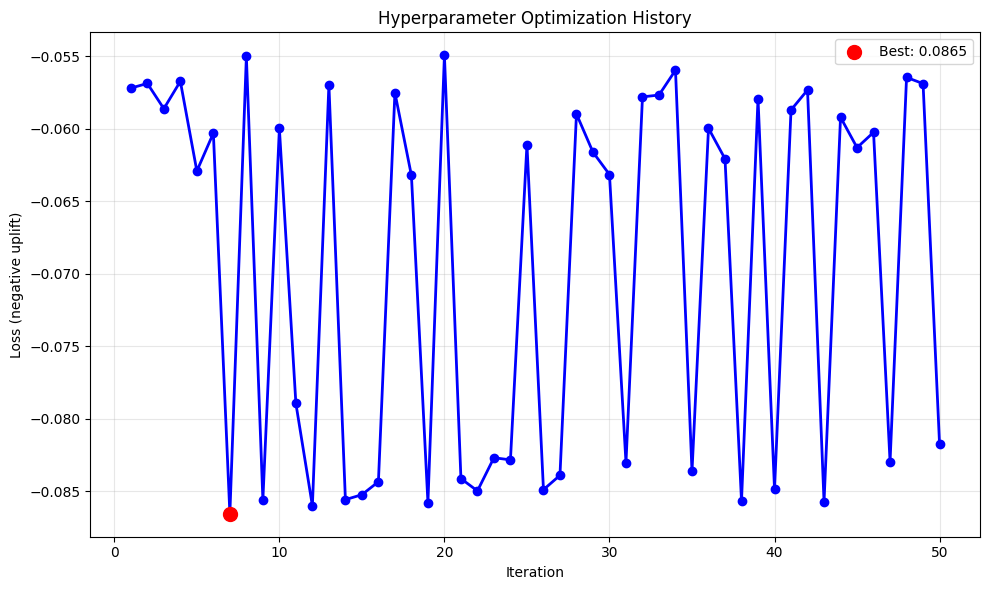

In [23]:
rf_tune.plot_optimization_history()

In [26]:
uplift_30_rf

np.float64(0.07792285917728031)